# Interpolating Time Series Data in Apache Spark and Python Pandas - Part 1: Pandas

Note: Pandas version 0.20.1 (May 2017) changed the grouping API. This post reflects the functionality of the updated version.

As we have all experienced (and I am sure suffered), real-world data is patchy most of the time and therefore a common first step in any data science task is data cleaning. Having recently moved from Pandas to Pyspark, I was used to the conveniences Pandas offers, which given to its distributed nature Pyspark is sometimes lacking. One of these features I have particularly been  missing recently is a straight-forward way of interpolating (or in-filling) time series data. Whilst the problem of in-filling missing values has been covered a few times (e.g. [here]), I was not able to find a source, which detailed the end-to-end process of generating the underlying time-grid and then subsequently filling in the missing values. This and the next post try to close this gap by detailing the process in both Pandas and Pyspark. This weeks post starts by demonstrating the process using Pandas data frames. Next week's post will show how to achieve the same functionality in PySpark. The full notebook for this post can be found [here in my github](https://github.com/walkenho/tales-of-1001-data/blob/master/timeseries-interpolation-in-spark/interpolating_time_series_p1_pandas.ipynb).

## Preparing the Data and Initial Visualization

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First we generate a pandas data frame df0 with some test data. We create a data set containing two houses and use a $sin$ and a $cos$ function to generate some read data for a set of dates. To generate the missing values, we randomly drop half of the entries. 

In [2]:
data = {'datetime': pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')\
                .append(pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')),
        'house' : ['house1' for i in range(31)] + ['house2' for i in range(31)],
        'readvalue':  [0.5 + 0.5*np.sin(2*np.pi/30*i) for i in range(31)]\
                    + [0.5 + 0.5*np.cos(2*np.pi/30*i) for i in range(31)]}
df0 = pd.DataFrame(data, columns = ['datetime', 'house', 'readvalue'])

# Randomly drop half the reads
random.seed(42)
df0 = df0.drop(random.sample(range(df0.shape[0]), k=int(df0.shape[0]/2)))

In [5]:
df0

,datetime,house,readvalue
0,2018-01-15,house1,0.500000
3,2018-01-18,house1,0.793893
4,2018-01-19,house1,0.871572
9,2018-01-24,house1,0.975528
10,2018-01-25,house1,0.933013
11,2018-01-26,house1,0.871572
16,2018-01-31,house1,0.396044
18,2018-02-02,house1,0.206107
19,2018-02-03,house1,0.128428
20,2018-02-04,house1,0.066987


This is how the data looks like. A $sin$ and a $cos$ with plenty of missing data points.

/home/campus-5/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


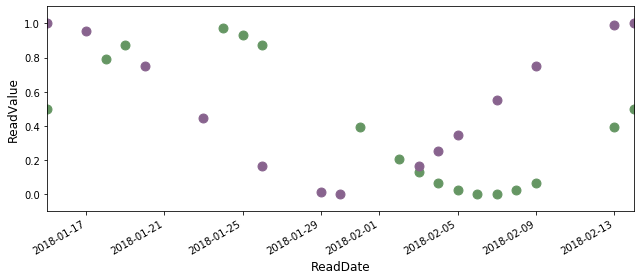

In [6]:
# Generating a plot of the data with missing values
# Setting figure properties
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,4),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate colors using nices seaborn color palette
colors = {"house1": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "house2": sns.color_palette("Set1", n_colors=8, desat=.5)[3]}

fig, ax = plt.subplots()

for myhouse in ["house1", "house2"]:
    ax.scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']),
               df0[df0.house==myhouse]['readvalue'],
               color=colors[myhouse],
               s=80)

ax.set_xlabel("ReadDate")
ax.set_ylabel("ReadValue")

# Format x-axis to properly displays dates
fig.autofmt_xdate()
ax.set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig1.png')
plt.show()

We will now look at three different methods of interpolating the missing read values: forward-filling, backward-filling and interpolating. Remember that it is crucial to choose the adequate interpolation method for the task at hand. Special care needs to be taken when looking at forecasting tasks (for example if you want to use your interpolated data for forecasting weather than you need to remember that you cannot interpolate the weather of today using the weather of tomorrow since it is still unknown).

In order to interpolate the data, we will make use of the `groupby()` function followed by `resample()`. However, first we need to convert the read dates to datetime format and set them as index of our dataframe:

In [7]:
df = df0.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
del df['datetime']

This is how the structure of the dataframe looks like now:

In [8]:
df.head(1)

,house,readvalue
datetime,,
2018-01-15,house1,0.5


## Interpolation 

Since we want to interpolate for each house separately, we need to group our data by 'house' before we can use the `resample()` function with the option 'D' to resample the data to daily frequency. 

The next step is then to use mean-filling, forward-filling or backward-filling to determine how the newly generated grid is supposed to be filled.

### mean()
Since we are strictly upsampling, using the `mean()` method, all missing read values are filled with NaNs:

In [8]:
df.groupby('house').resample('D').mean().head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16        NaN
       2018-01-17        NaN
       2018-01-18   0.793893

### pad() - forward filling
Using .pad() instead of .mean() forward-fills the NaNs.

In [11]:
df_pad = df.groupby('house')\
            .resample('D')\
            .pad().drop('house', axis=1)
df_pad.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.500000
       2018-01-17   0.500000
       2018-01-18   0.793893

### bfill - backward filling
Using .bfill() instead of .mean() backward-fills the NaNs:

In [10]:
df_bfill = df.groupby('house')\
            .resample('D')\
            .bfill()\
            .drop('house', axis=1)
df_bfill.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.793893
       2018-01-17   0.793893
       2018-01-18   0.793893

### interpolate() - interpolating
If we want to mean interpolate the missing values, we need to do this in two steps. First, we generate the data grid by using `mean()` to generate NaNs. Afterwards we fill the NaNs by interpolated values by calling the `interpolate()` method on the readvalue column:

In [11]:
df_interpol = df.groupby('house')\
                .resample('D')\
                .mean()
df_interpol['readvalue'] = df_interpol['readvalue'].interpolate()
df_interpol.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.597964
       2018-01-17   0.695928
       2018-01-18   0.793893

## Visualizing the Results
Finally we can visualize the three different filling methods to get a better idea of their results. The opaque dots show the interpolated values.

We can clearly see how in the top figure, the gaps have been filled with the last known value, in the middle figure, the gaps have been filled with the next value to come and in the bottom figure the difference has been interpolated.

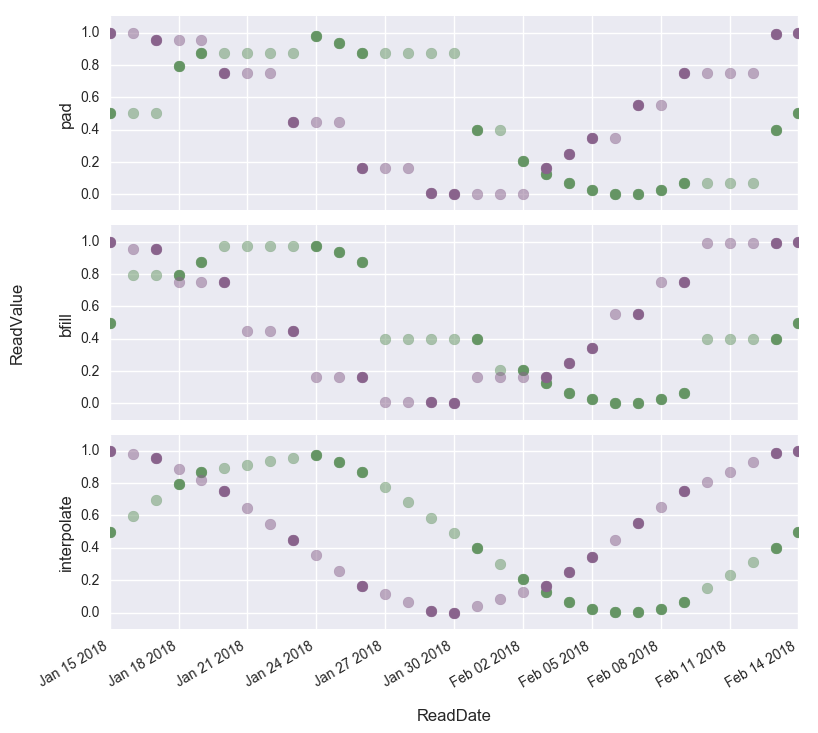

In [24]:
# Setting figure parameters
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,8),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate a list of dataframes to loop over
dfs = []
dfs.append(df_pad.reset_index())
dfs.append(df_bfill.reset_index())
dfs.append(df_interpol.reset_index())

ylabel = ['pad', 'bfill', 'interpolate']

n_df = len(dfs)
fig, ax = plt.subplots(n_df)

for myhouse in ["house1", "house2"]:

    for i in range(n_df):
        ax[i].scatter(pd.DatetimeIndex(dfs[i][dfs[i].house==myhouse]['datetime']), pd.to_numeric(dfs[i][dfs[i].house==myhouse]['readvalue']), color=colors[myhouse], s=60, alpha=0.5)
        ax[i].scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']), pd.to_numeric(df0[df0.house==myhouse]['readvalue']), color=colors[myhouse], s=60)
        
        ax[i].set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
        ax[i].set_ylim([-0.1, 1.1])

fig.autofmt_xdate()

for i in range(n_df):
    ax[i].set_ylabel(ylabel[i])

# Adding another subplot in order to have common y-label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the common axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('ReadDate', labelpad=40)
plt.ylabel('ReadValue', labelpad=40)

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig2.png')
plt.show()
plt.close()

## Summary

In this blog post we have seen how we can use Python Pandas to interpolate time series data using either backfill, forward fill or interpolation methods. Having used this example to set the scene, in the next post, we will see how to achieve the same thing using PySpark. 